# Análisis de datos de accidentes de tránsito

## 1. Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. Carga y vista inicial del dataset
- Descripción breve de la fuente de datos
- Mostrar las primeras filas y dimensiones

In [2]:
# Cargar dataset
df = pd.read_csv('/kaggle/input/traffic-accidents/traffic_accidents.csv', parse_dates=['crash_date'])

/tmp/ipykernel_36/3418026439.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/kaggle/input/traffic-accidents/traffic_accidents.csv', parse_dates=['crash_date'])


## 3. Limpieza de datos
- Eliminación de columnas no relevantes

In [3]:
drop_cols = [
    'crash_date', 'num_units',
    'crash_hour', 'crash_day_of_week', 'crash_month'
]
df = df.drop(columns=drop_cols)

## 4. Distribución de causas principales
- Conteo y visualización de `prim_contributory_cause`

In [4]:
# Exploración de la columna 'prim_contributory_cause'
# Identificar categorías únicas y conteo de repeticiones
cause_counts = df['prim_contributory_cause'].value_counts(dropna=False)
print("Categorías en 'prim_contributory_cause' y sus frecuencias:\n", cause_counts)

Categorías en 'prim_contributory_cause' y sus frecuencias:
 prim_contributory_cause
UNABLE TO DETERMINE                                                                 58316
FAILING TO YIELD RIGHT-OF-WAY                                                       42914
FOLLOWING TOO CLOSELY                                                               19084
DISREGARDING TRAFFIC SIGNALS                                                        14591
IMPROPER TURNING/NO SIGNAL                                                          12643
FAILING TO REDUCE SPEED TO AVOID CRASH                                              10676
IMPROPER OVERTAKING/PASSING                                                          8302
DISREGARDING STOP SIGN                                                               6749
IMPROPER LANE USAGE                                                                  6462
NOT APPLICABLE                                                                       5241
DRIVING SKILLS/K

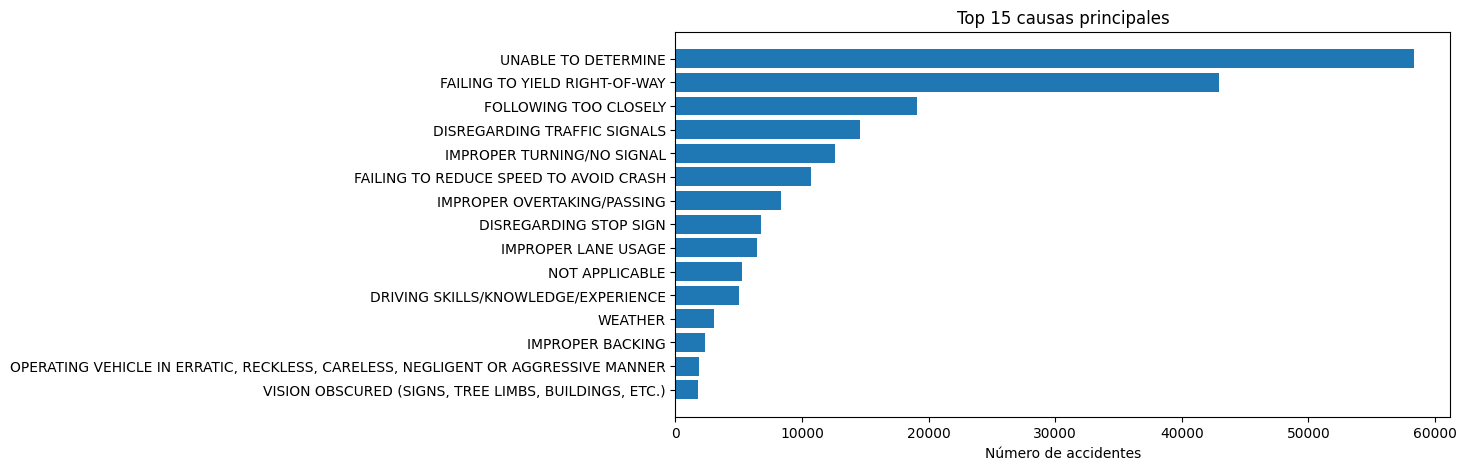

In [5]:
# Conteo de causas principales
cause_counts = df['prim_contributory_cause'].value_counts(dropna=False)
# Gráfica de barras para las 10 causas más frecuentes
top15 = cause_counts.head(15)
plt.figure(figsize=(10,5))
plt.barh(top15.index, top15.values)
plt.title('Top 15 causas principales')
plt.xlabel('Número de accidentes')
plt.gca().invert_yaxis()
plt.show()

In [6]:
# Filtramos causas relacionadas con condiciones de la calle
# Por ejemplo, buscar palabras clave como 'road', 'surface', 'defect'
keywords = ['weather', 'vision obscured', 'road construction', 'animal, object', 'road engineering', 'obstructed crosswalks', 'holes']
mask = cause_counts.index.str.contains('|'.join(keywords), case=False, na=False)
road_causes = cause_counts[mask]
print("\nCausas relacionadas con condiciones de la calle:\n", road_causes)



Causas relacionadas con condiciones de la calle:
 prim_contributory_cause
WEATHER                                                 3074
VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)    1793
ROAD CONSTRUCTION/MAINTENANCE                            298
EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST        284
ROAD ENGINEERING/SURFACE/MARKING DEFECTS                 179
OBSTRUCTED CROSSWALKS                                     48
Name: count, dtype: int64


## 5. Variables de interés
- Listado de columnas seleccionadas para análisis: `traffic_control_device`, `weather_condition`, etc.

In [7]:
# Extraemos lista de todas las causas principales
causas_calle = df['prim_contributory_cause'].dropna().unique().tolist()

# Filtramos el DataFrame por esas causas
df_filtrado = df[df['prim_contributory_cause'].isin(causas_calle)]

# Estas son las columnas a analizar
cols = [
    'traffic_control_device',
    'weather_condition',
    'lighting_condition',
    'trafficway_type',
    'alignment',
    'roadway_surface_cond',
    'road_defect'
]

## 6. Distribución por condición
Para cada variable de `cols`, mostramos un gráfico de barras de sus conteos.

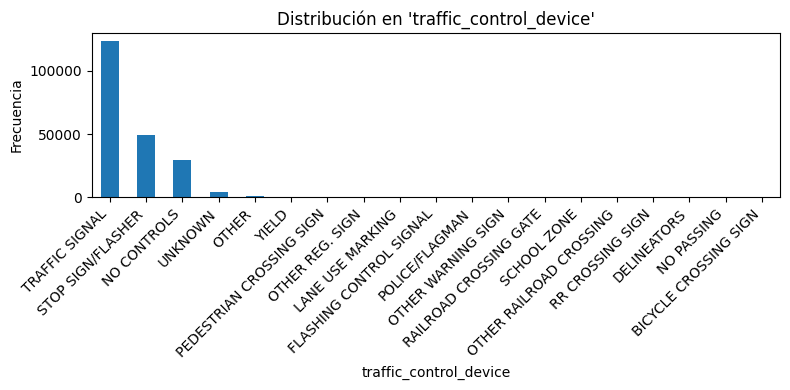

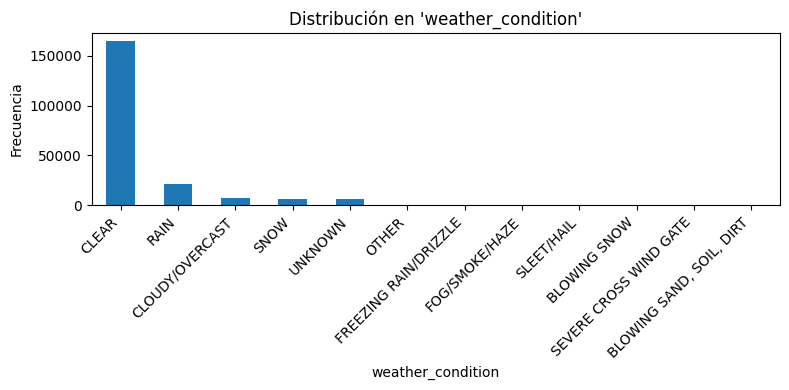

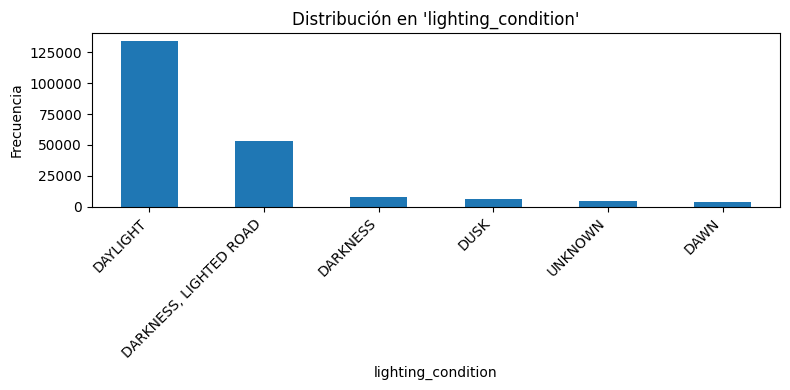

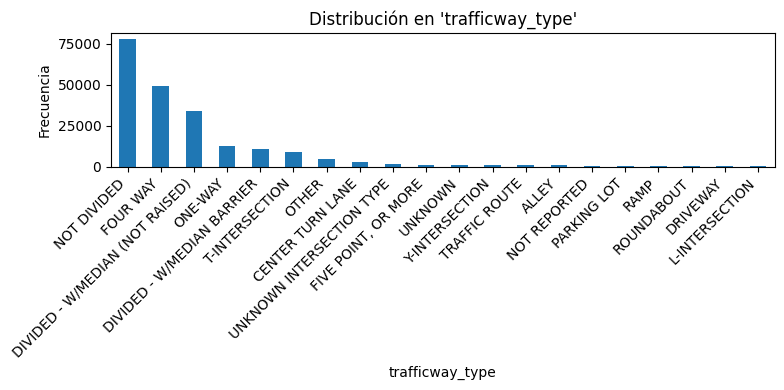

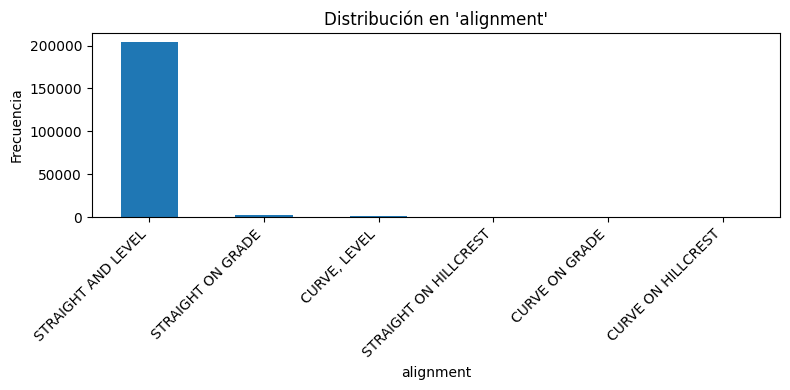

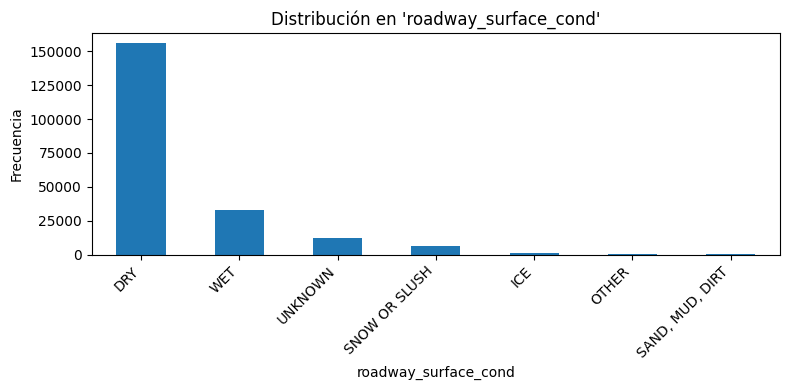

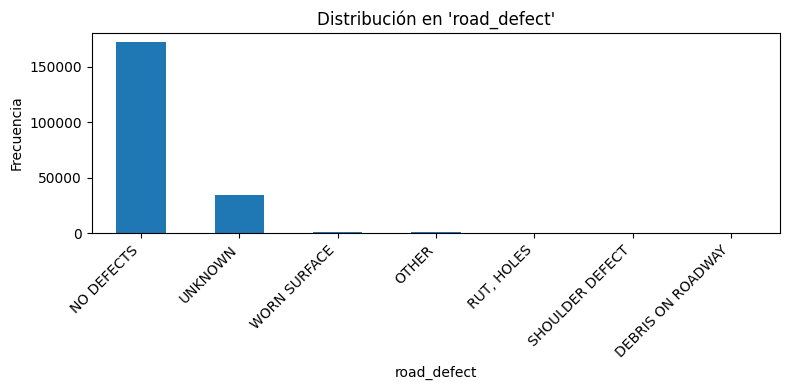

In [8]:
for c in cols:
    counts = df[c].value_counts(dropna=False)
    plt.figure(figsize=(8,4))
    counts.plot(kind='bar')
    plt.title(f"Distribución en '{c}'")
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [9]:
# Recorremos cada columna y mostramos su value_counts()
for c in cols:
    print(f"\n--- Conteo en columna '{c}' ---")
    print(df_filtrado[c].value_counts(dropna=False))


--- Conteo en columna 'traffic_control_device' ---
traffic_control_device
TRAFFIC SIGNAL              123944
STOP SIGN/FLASHER            49139
NO CONTROLS                  29508
UNKNOWN                       4455
OTHER                          670
YIELD                          468
PEDESTRIAN CROSSING SIGN       247
OTHER REG. SIGN                181
LANE USE MARKING               153
FLASHING CONTROL SIGNAL        150
POLICE/FLAGMAN                 104
OTHER WARNING SIGN              95
RAILROAD CROSSING GATE          78
SCHOOL ZONE                     33
OTHER RAILROAD CROSSING         23
RR CROSSING SIGN                18
DELINEATORS                     17
NO PASSING                      12
BICYCLE CROSSING SIGN           11
Name: count, dtype: int64

--- Conteo en columna 'weather_condition' ---
weather_condition
CLEAR                       164700
RAIN                         21703
CLOUDY/OVERCAST               7533
SNOW                          6871
UNKNOWN                      

## 7. Definición de nivel de riesgo
- Asignación numérica de `most_severe_injury` a `risk_level`

In [10]:
# Ver todas las categorías de lesión severa
print("Categorías en most_severe_injury:\n", df['most_severe_injury'].value_counts(dropna=False))

Categorías en most_severe_injury:
 most_severe_injury
NO INDICATION OF INJURY     154789
NONINCAPACITATING INJURY     31527
REPORTED, NOT EVIDENT        16075
INCAPACITATING INJURY         6564
FATAL                          351
Name: count, dtype: int64


In [11]:
# Definimos nivel de riesgo
risk_map = {
    'FATAL': 5,
    'INCAPACITATING INJURY': 4,
    'NONINCAPACITATING INJURY': 3,
    'REPORTED, NOT EVIDENT': 2,
    'NO INDICATION OF INJURY': 1
}

# Añadimos una columna numérica con ese nivel
df['risk_level'] = df['most_severe_injury'].map(risk_map)

# Función para conteo cruzado
def cruzar_severidad(df, causas, columna):
    df_sub = df[df['prim_contributory_cause'].isin(causas)]
    tabla = (
        df_sub.groupby([columna, 'most_severe_injury'])
              .size()
              .unstack(fill_value=0)
    )
    print(f"\n=== Conteo de severidad en '{columna}' para causas {causas} ===")
    display(tabla)   # en Jupyter mostrará la tabla bonita

In [12]:
features = [
    'traffic_control_device',
    'weather_condition',
    'lighting_condition',
    'roadway_surface_cond',
    'road_defect'
]

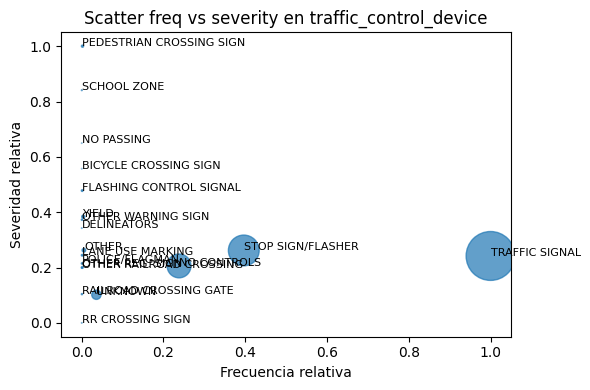

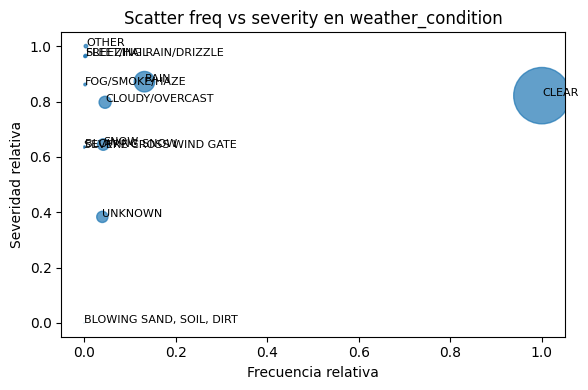

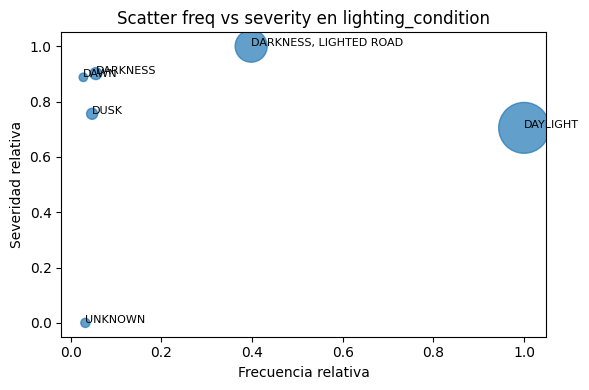

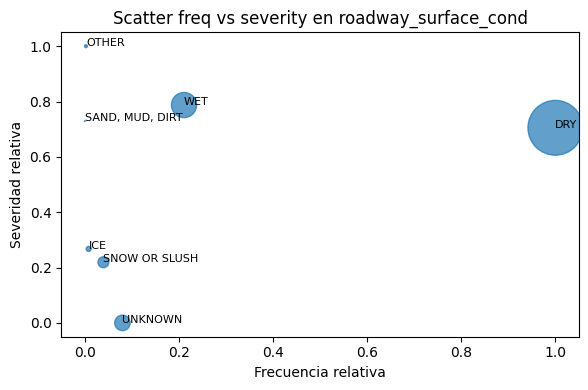

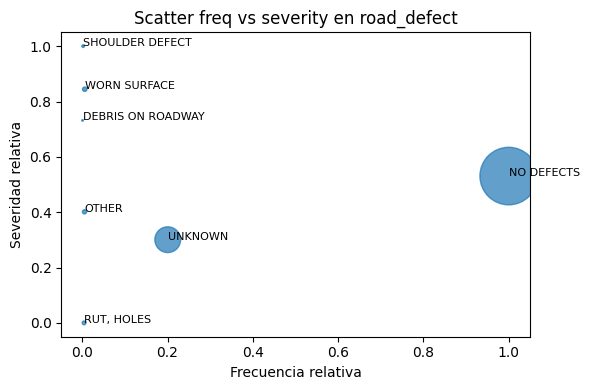

Ranking global: weather_condition         0.806859
lighting_condition        0.774199
roadway_surface_cond      0.671793
road_defect               0.528842
traffic_control_device    0.287957
dtype: float64


In [15]:
# Para cada feature, ya fue calculado un DataFrame stats con columnas:
#   - category (ej. weather_condition)
#   - N
#   - risk_index

def global_risk(stats):
    # Pondera cada risk_index por N y divide por suma de N
    total = stats['N'].sum()
    return (stats['risk_index'] * stats['N']).sum() / total

globals = {}

for f in features:
    grp = df.groupby(f).agg(N=('risk_level','size'), avg_risk=('risk_level','mean')).reset_index()
    grp['rel_freq'] = grp['N']/grp['N'].max()
    grp['rel_severity'] = (grp['avg_risk']-grp['avg_risk'].min())/(grp['avg_risk'].max()-grp['avg_risk'].min())
    alpha = 0.1
    grp['risk_index'] = alpha*grp['rel_freq'] + (1-alpha)*grp['rel_severity']
    # Gráfica scatter: frecuencia vs severidad coloreada por risk_index
    plt.figure(figsize=(6,4))
    plt.scatter(grp['rel_freq'], grp['rel_severity'], s=grp['N']/100, alpha=0.7)
    for _, row in grp.iterrows():
        plt.text(row['rel_freq'], row['rel_severity'], row[f], fontsize=8)
    plt.title(f'Scatter freq vs severity en {f}')
    plt.xlabel('Frecuencia relativa')
    plt.ylabel('Severidad relativa')
    plt.tight_layout()
    plt.show()
    globals[f] = ((grp['risk_index'] * grp['N']).sum() / grp['N'].sum())
ranking_global = pd.Series(globals).sort_values(ascending=False)
print('Ranking global:', ranking_global)

## 9. Análisis específico por causa
- **a) Clima**

In [16]:
# a) Clima
cruzar_severidad(
    df,
    causas=['WEATHER'],
    columna='weather_condition'
)


=== Conteo de severidad en 'weather_condition' para causas ['WEATHER'] ===


most_severe_injury,FATAL,INCAPACITATING INJURY,NO INDICATION OF INJURY,NONINCAPACITATING INJURY,"REPORTED, NOT EVIDENT"
weather_condition,,,,,
BLOWING SNOW,0,1,20,2,3
CLEAR,1,9,273,32,29
CLOUDY/OVERCAST,0,0,43,5,4
FOG/SMOKE/HAZE,0,0,11,4,1
FREEZING RAIN/DRIZZLE,0,1,43,5,2
OTHER,0,2,35,9,6
RAIN,0,48,877,236,123
SEVERE CROSS WIND GATE,0,0,6,0,0
SLEET/HAIL,0,2,38,10,3


In [17]:
# Filtrar sólo las filas cuya causa sea 'WEATHER'
df_weather = df[df['prim_contributory_cause']=='WEATHER'].copy()

# Mapear niveles de riesgo
df_weather['risk_level'] = df_weather['most_severe_injury'].map(risk_map)

# Agrupar por condición y calcular:
#   - N: número total de accidentes
#   - avg_risk: riesgo medio
stats = (
    df_weather
    .groupby('weather_condition')
    .agg(
        N=('risk_level','size'),
        avg_risk=('risk_level','mean')
    )
    .reset_index()
)

# Normalización
stats['rel_freq']     = stats['N'] / stats['N'].max()
stats['rel_severity'] = (stats['avg_risk'] - stats['avg_risk'].min()) / \
                        (stats['avg_risk'].max() - stats['avg_risk'].min())

alpha = 0.1
stats['risk_index'] = alpha*stats['rel_freq'] + (1-alpha)*stats['rel_severity']
stats = stats.sort_values('risk_index', ascending=False)
print(stats[['weather_condition','N','avg_risk','risk_index']])

         weather_condition     N  avg_risk  risk_index
6                     RAIN  1284  1.575545    0.997850
5                    OTHER    52  1.576923    0.904050
3           FOG/SMOKE/HAZE    16  1.562500    0.878746
8               SLEET/HAIL    53  1.547170    0.857713
0             BLOWING SNOW    26  1.384615    0.602025
1                    CLEAR   344  1.360465    0.589117
10                 UNKNOWN    11  1.363636    0.568129
4    FREEZING RAIN/DRIZZLE    51  1.294118    0.462795
9                     SNOW  1179  1.237489    0.462306
2          CLOUDY/OVERCAST    52  1.269231    0.424050
7   SEVERE CROSS WIND GATE     6  1.000000    0.000467


### 9. a) Gráficas para Clima
- Barras de `risk_index` por condición meteorológica

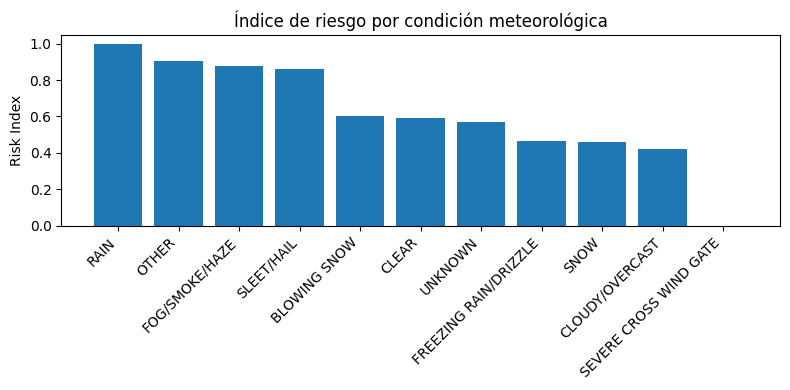

In [18]:
plt.figure(figsize=(8,4))
plt.bar(stats['weather_condition'], stats['risk_index'])
plt.xticks(rotation=45, ha='right')
plt.title('Índice de riesgo por condición meteorológica')
plt.ylabel('Risk Index')
plt.tight_layout()
plt.show()

- **b) Visibilidad**

In [19]:
# b) Visibilidad
cruzar_severidad(
    df,
    causas=['VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)'],
    columna='lighting_condition'
)


=== Conteo de severidad en 'lighting_condition' para causas ['VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)'] ===


most_severe_injury,INCAPACITATING INJURY,NO INDICATION OF INJURY,NONINCAPACITATING INJURY,"REPORTED, NOT EVIDENT"
lighting_condition,,,,
DARKNESS,8,16,4,4
"DARKNESS, LIGHTED ROAD",19,161,48,21
DAWN,3,18,9,1
DAYLIGHT,78,829,376,128
DUSK,4,40,10,10
UNKNOWN,0,6,0,0


In [20]:
df_lighting = df[df['prim_contributory_cause']=='VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)'].copy()

# Mapear niveles de riesgo
df_lighting['risk_level'] = df_lighting['most_severe_injury'].map(risk_map)

# Agrupar por condición y calcular:
#   - N: número total de accidentes
#   - avg_risk: riesgo medio
stats = (
    df_lighting
    .groupby('lighting_condition')
    .agg(
        N=('risk_level','size'),
        avg_risk=('risk_level','mean')
    )
    .reset_index()
)

# Normalización
stats['rel_freq']     = stats['N'] / stats['N'].max()
stats['rel_severity'] = (stats['avg_risk'] - stats['avg_risk'].min()) / \
                        (stats['avg_risk'].max() - stats['avg_risk'].min())

alpha = 0.1
stats['risk_index'] = alpha*stats['rel_freq'] + (1-alpha)*stats['rel_severity']
stats = stats.sort_values('risk_index', ascending=False)
print(stats[['lighting_condition','N','avg_risk','risk_index']])

       lighting_condition     N  avg_risk  risk_index
0                DARKNESS    32  2.125000    0.902268
3                DAYLIGHT  1411  1.789511    0.731609
2                    DAWN    31  1.903226    0.724778
1  DARKNESS, LIGHTED ROAD   249  1.698795    0.576683
4                    DUSK    64  1.656250    0.529536
5                 UNKNOWN     6  1.000000    0.000425


### 9. b) Gráficas para Visibilidad
- Barras de `risk_index` por condición de iluminación

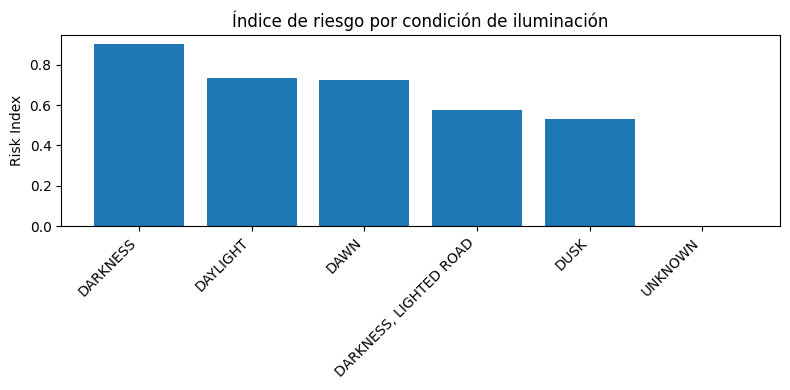

In [21]:
plt.figure(figsize=(8,4))
plt.bar(stats['lighting_condition'], stats['risk_index'])
plt.xticks(rotation=45, ha='right')
plt.title('Índice de riesgo por condición de iluminación')
plt.ylabel('Risk Index')
plt.tight_layout()
plt.show()

- **c) Defectos**

In [22]:
# c) Defectos / obras en vía
cruzar_severidad(
    df,
    causas=[
        'ROAD CONSTRUCTION/MAINTENANCE',
        'ROAD ENGINEERING/SURFACE/MARKING DEFECTS',
    ],
    columna='road_defect'
)


=== Conteo de severidad en 'road_defect' para causas ['ROAD CONSTRUCTION/MAINTENANCE', 'ROAD ENGINEERING/SURFACE/MARKING DEFECTS'] ===


most_severe_injury,INCAPACITATING INJURY,NO INDICATION OF INJURY,NONINCAPACITATING INJURY,"REPORTED, NOT EVIDENT"
road_defect,,,,
DEBRIS ON ROADWAY,0,15,4,2
NO DEFECTS,3,149,18,11
OTHER,1,81,12,5
"RUT, HOLES",2,110,9,5
SHOULDER DEFECT,0,1,1,0
UNKNOWN,0,27,2,0
WORN SURFACE,0,13,6,0


In [23]:
# Filtramos las filas cuyas causas estén en la lista
causas_defectos = [
    'ROAD CONSTRUCTION/MAINTENANCE',
    'ROAD ENGINEERING/SURFACE/MARKING DEFECTS'
]
df_defect = df[df['prim_contributory_cause'].isin(causas_defectos)].copy()

# Mapear niveles de riesgo
df_defect['risk_level'] = df_defect['most_severe_injury'].map(risk_map)

# Agrupar y calcular N y avg_risk por defecto de vía
stats = (
    df_defect
    .groupby('road_defect')
    .agg(
        N=('risk_level','size'),
        avg_risk=('risk_level','mean')
    )
    .reset_index()
)

# Normalizar
stats['rel_freq']     = stats['N'] / stats['N'].max()
stats['rel_severity'] = (stats['avg_risk'] - stats['avg_risk'].min()) / \
                        (stats['avg_risk'].max() - stats['avg_risk'].min())

# Calcular índice de riesgo (ajusta α a tu preferencia)
alpha = 0.1
stats['risk_index'] = alpha * stats['rel_freq'] + (1 - alpha) * stats['rel_severity']

# Mostrar resultados ordenados
stats = stats.sort_values('risk_index', ascending=False)
print(stats[['road_defect','N','avg_risk','risk_index']])

         road_defect    N  avg_risk  risk_index
4    SHOULDER DEFECT    2  2.000000    0.901105
6       WORN SURFACE   19  1.631579    0.525866
0  DEBRIS ON ROADWAY   21  1.476190    0.364745
1         NO DEFECTS  181  1.309392    0.279006
2              OTHER   99  1.323232    0.248151
3         RUT, HOLES  126  1.230159    0.165899
5            UNKNOWN   29  1.137931    0.016022


### 9. c) Gráficas para Defectos de la calle
- Barras de `risk_index` por condiciones de la calle y sus defectos

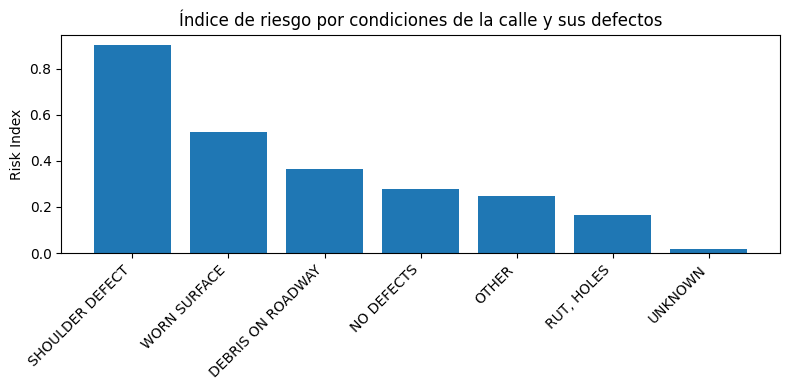

In [24]:
plt.figure(figsize=(8,4))
plt.bar(stats['road_defect'], stats['risk_index'])
plt.xticks(rotation=45, ha='right')
plt.title('Índice de riesgo por condiciones de la calle y sus defectos')
plt.ylabel('Risk Index')
plt.tight_layout()
plt.show()

- **d) Señalización**

In [25]:
# d) Señalización
cruzar_severidad(
    df,
    causas=[
        'DISREGARDING TRAFFIC SIGNALS',
        'IMPROPER TURNING/NO SIGNAL'
    ],
    columna='traffic_control_device'
)


=== Conteo de severidad en 'traffic_control_device' para causas ['DISREGARDING TRAFFIC SIGNALS', 'IMPROPER TURNING/NO SIGNAL'] ===


most_severe_injury,FATAL,INCAPACITATING INJURY,NO INDICATION OF INJURY,NONINCAPACITATING INJURY,"REPORTED, NOT EVIDENT"
traffic_control_device,,,,,
DELINEATORS,0,0,2,0,0
FLASHING CONTROL SIGNAL,0,2,23,7,2
LANE USE MARKING,0,0,12,1,2
NO CONTROLS,3,41,1720,283,147
OTHER,0,0,27,5,2
OTHER RAILROAD CROSSING,0,0,1,0,0
OTHER REG. SIGN,0,0,18,1,1
OTHER WARNING SIGN,0,0,5,0,1
PEDESTRIAN CROSSING SIGN,0,0,2,2,2


In [26]:
# Filtramos las filas cuyas causas estén en la lista
causas_señales = [
    'DISREGARDING TRAFFIC SIGNALS',
    'IMPROPER TURNING/NO SIGNAL'
]
df_signal = df[df['prim_contributory_cause'].isin(causas_señales)].copy()

# Mapear niveles de riesgo
df_signal['risk_level'] = df_signal['most_severe_injury'].map(risk_map)

# Agrupar y calcular N y avg_risk por defecto de vía
stats = (
    df_signal
    .groupby('traffic_control_device')
    .agg(
        N=('risk_level','size'),
        avg_risk=('risk_level','mean')
    )
    .reset_index()
)

# Normalizar
stats['rel_freq']     = stats['N'] / stats['N'].max()
stats['rel_severity'] = (stats['avg_risk'] - stats['avg_risk'].min()) / \
                        (stats['avg_risk'].max() - stats['avg_risk'].min())

# Calcular índice de riesgo (ajusta α a tu preferencia)
alpha = 0.1
stats['risk_index'] = alpha * stats['rel_freq'] + (1 - alpha) * stats['rel_severity']

# Mostrar resultados ordenados
stats = stats.sort_values('risk_index', ascending=False)
print(stats[['traffic_control_device','N','avg_risk','risk_index']])

      traffic_control_device      N  avg_risk  risk_index
11               SCHOOL ZONE      3  2.666667    0.900013
8   PEDESTRIAN CROSSING SIGN      6  2.000000    0.540026
13            TRAFFIC SIGNAL  22780  1.642801    0.447112
1    FLASHING CONTROL SIGNAL     34  1.647059    0.349561
3                NO CONTROLS   2194  1.386509    0.218346
9             POLICE/FLAGMAN     10  1.400000    0.216044
12         STOP SIGN/FLASHER   1796  1.382517    0.214443
4                      OTHER     34  1.352941    0.190737
14                   UNKNOWN    290  1.272414    0.148376
2           LANE USE MARKING     15  1.266667    0.144066
15                     YIELD     35  1.200000    0.108154
7         OTHER WARNING SIGN      6  1.166667    0.090026
6            OTHER REG. SIGN     20  1.150000    0.081088
10    RAILROAD CROSSING GATE      8  1.125000    0.067535
0                DELINEATORS      2  1.000000    0.000009
5    OTHER RAILROAD CROSSING      1  1.000000    0.000004


### 9. d) Gráficas para señalización
- Barras de `risk_index` por la señalización de la calle

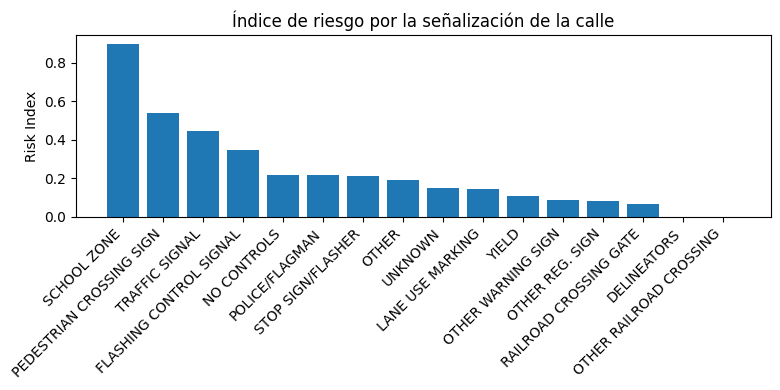

In [27]:
plt.figure(figsize=(8,4))
plt.bar(stats['traffic_control_device'], stats['risk_index'])
plt.xticks(rotation=45, ha='right')
plt.title('Índice de riesgo por la señalización de la calle')
plt.ylabel('Risk Index')
plt.tight_layout()
plt.show()

### Este Adicional analiza la condicion del suelo con su clima y su indice de riesgo

In [28]:
# Filtramos las filas cuyas causas estén en la lista
causas_speed_2 = [
    'WEATHER'
]
df_speed_2 = df[df['prim_contributory_cause'].isin(causas_speed_2)].copy()

# Mapear niveles de riesgo
df_speed_2['risk_level'] = df_speed_2['most_severe_injury'].map(risk_map)

# Agrupar y calcular N y avg_risk por defecto de vía
stats = (
    df_speed_2
    .groupby('roadway_surface_cond')
    .agg(
        N=('risk_level','size'),
        avg_risk=('risk_level','mean')
    )
    .reset_index()
)

# Normalizar
stats['rel_freq']     = stats['N'] / stats['N'].max()
stats['rel_severity'] = (stats['avg_risk'] - stats['avg_risk'].min()) / \
                        (stats['avg_risk'].max() - stats['avg_risk'].min())

# Calcular índice de riesgo (ajusta α a tu preferencia)
alpha = 0.9
stats['risk_index'] = alpha * stats['rel_freq'] + (1 - alpha) * stats['rel_severity']

# Mostrar resultados ordenados
stats = stats.sort_values('risk_index', ascending=False)
print(stats[['roadway_surface_cond','N','avg_risk','risk_index']])

  roadway_surface_cond     N  avg_risk  risk_index
5                  WET  1531  1.551927    0.942391
3        SNOW OR SLUSH  1033  1.234269    0.608799
1                  ICE   416  1.252404    0.248427
0                  DRY    83  1.698795    0.110065
2                OTHER     2  2.000000    0.101176
4              UNKNOWN     9  1.222222    0.005291


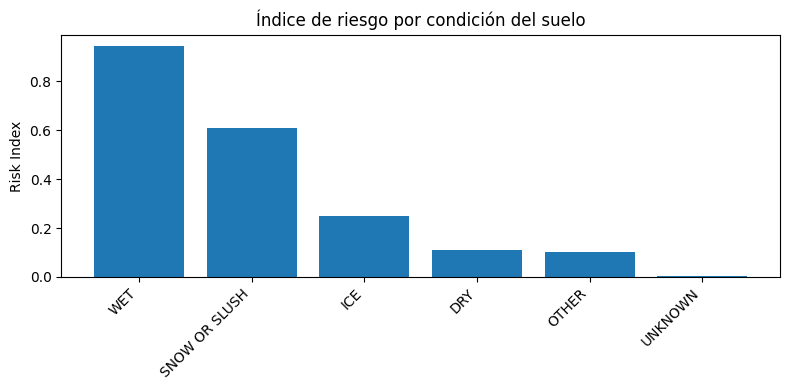

In [29]:
plt.figure(figsize=(8,4))
plt.bar(stats['roadway_surface_cond'], stats['risk_index'])
plt.xticks(rotation=45, ha='right')
plt.title('Índice de riesgo por condición del suelo')
plt.ylabel('Risk Index')
plt.tight_layout()
plt.show()

## 10. Conclusiones

- El análisis exploratorio reveló que las variables con mayor índice de riesgo global son:
  1. **Condición climática** (`weather_condition`), por su alta frecuencia de accidentes y severidad relativa.
  2. **Condición de la superficie vial** (`roadway_surface_cond`), donde los estados **wet** y **dry** resultaron ser las categorías más críticas.

- **Decisión de diseño del modelo de clasificación**:
  - Para optimizar tiempo de entrenamiento e inferencia, se concentrará el modelo de clasificación predictiva en estas dos variables críticas (clima y condición del suelo). Esta simplificación reduce la dimensionalidad del espacio de entrada, disminuye el costo computacional y mantiene un nivel adecuado de precisión.

- **Componentes complementarios**:
  - Se implementará adicionalmente un **modelo de detección de huecos** en la vía (por ejemplo, usando una arquitectura YOLO). Este modelo contará y ubicará los huecos presentes, lo que permitirá ajustar dinámicamente el nivel de riesgo calculado por el clasificador.
  - La información del conteo de huecos se integrará como un factor de corrección: a mayor número de huecos, se incrementa el score de riesgo final.

- **Ventajas de la arquitectura híbrida**:
  1. Minimiza recursos y tiempo de cómputo al usar un clasificador ligero.
  2. Aporta granularidad adicional con la detección de huecos, mejorando la precisión en tramos complejos.
  3. Facilita el despliegue en entornos con limitaciones de hardware (e.g., edge devices en vehículos).

- **Próximos pasos**:
  1. Entrenar y validar el clasificador con datos históricos etiquetados según clima y superficie.
  2. Ajustar el detector de huecos y calibrar el impacto de su conteo en el índice de riesgo.
  3. Desplegar el sistema de forma incremental para recopilar retroalimentación en campo y refinar modelos.